<a href="https://colab.research.google.com/github/radityadhaaa/image-classification/blob/main/imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi Image**
## Raditya Adha Rahman

### Kode ini bertujuan untuk membangun model klasifikasi gambar menggunakan dataset “rockpaperscissors”. Model ini akan dilatih untuk mengenali tiga kelas gambar: kertas, batu, dan gunting. Berikut adalah langkah-langkah utama yang dilakukan dalam kode ini:




## Mengunduh dan Mengekstrak
Mengunduh dataset: Dataset diunduh dari URL yang diberikan menggunakan wget.

Mengekstrak file zip: File zip yang telah diunduh diekstrak menggunakan unzip.

In [1]:
# Mengunduh dataset dari URL yang diberikan
!wget https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip
# Mengekstrak file zip yang telah diunduh
!unzip rockpaperscissors.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: rockpaperscissors/scissors/KNNsNhduqSfuqEK5.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._KNNsNhduqSfuqEK5.png  
  inflating: rockpaperscissors/scissors/xAnfzBYnsnuru9Nf.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._xAnfzBYnsnuru9Nf.png  
  inflating: rockpaperscissors/scissors/caj9PiWZ2BenuxXF.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._caj9PiWZ2BenuxXF.png  
  inflating: rockpaperscissors/scissors/5CzwWCDnxKOJz5T0.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._5CzwWCDnxKOJz5T0.png  
  inflating: rockpaperscissors/scissors/7dBQ0fOpCs03OmnR.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._7dBQ0fOpCs03OmnR.png  
  inflating: rockpaperscissors/scissors/DXQaN15KphkE4i7z.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._DXQaN15KphkE4i7z.png  
  inflating: rockpaperscissors/scissors/0CSaM2vL2cWX6Cay.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._0CSaM

## Import Library yang Diperlukan
Berbagai library dari TensorFlow dan Keras diimpor untuk pemrosesan gambar, pembuatan model, dan callback.
Library tambahan seperti numpy untuk manipulasi array, matplotlib untuk visualisasi, dan google.colab.files untuk pengunggahan file juga diimpor.

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

## Menentukan Direktori Dataset

Direktori dasar tempat dataset berada setelah diekstraksi ditentukan dengan variabel base_dir.

In [3]:
# Menentukan direktori dasar tempat dataset berada
base_dir = 'rockpaperscissors/rps-cv-images'

## Membuat ImageDataGenerator dengan Augmentasi Gambar

Objek ImageDataGenerator dibuat dengan augmentasi gambar untuk memperkaya data training. Augmentasi ini termasuk rescaling, rotasi, pergeseran, shear, zoom, dan flipping.

In [4]:
# Membuat objek ImageDataGenerator dengan augmentasi gambar untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Rotasi gambar hingga 40 derajat
    width_shift_range=0.2,  # Pergeseran lebar gambar hingga 20%
    height_shift_range=0.2,  # Pergeseran tinggi gambar hingga 20%
    shear_range=0.2,  # Shear transformasi hingga 20%
    zoom_range=0.2,  # Zoom gambar hingga 20%
    horizontal_flip=True,  # Membalik gambar secara horizontal
    fill_mode='nearest',  # Mengisi piksel yang hilang dengan metode 'nearest'
    validation_split=0.4  # 40% dari dataset untuk validation set
)

## Membuat Generator untuk Training dan Validation Set

Generator dibuat untuk training set dan validation set menggunakan ImageDataGenerator. Generator ini akan memuat gambar dari direktori yang telah ditentukan dan menerapkan augmentasi yang telah ditetapkan.

In [5]:
# Membuat generator untuk training set
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # Mengubah ukuran gambar menjadi 150x150 piksel
    batch_size=32,  # Ukuran batch
    class_mode='categorical',  # Klasifikasi kategori
    subset='training'  # Menentukan subset sebagai training set
)

Found 1314 images belonging to 3 classes.


In [6]:
# Membuat generator untuk validation set
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Menentukan subset sebagai validation set
)

Found 874 images belonging to 3 classes.


## Callback untuk Menghentikan Pelatihan dan Learning Rate Scheduler

Callback custom MyCallback dibuat untuk menghentikan pelatihan jika akurasi dan val_accuracy mencapai lebih dari 98%. Ini membantu mencegah overfitting dan menghemat waktu pelatihan.

Fungsi scheduler dibuat untuk mengatur learning rate selama pelatihan. Learning rate akan dikurangi sebesar 90% setelah 10 epoch untuk membantu model beradaptasi dengan lebih baik.

In [7]:
# Callback untuk menghentikan pelatihan jika akurasi dan val_accuracy mencapai threshold tertentu
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.98:
            print("\nAkurasi dan val_accuracy telah mencapai > 98%, menghentikan pelatihan!")
            self.model.stop_training = True

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.1

lr_scheduler = LearningRateScheduler(scheduler)

## Early Stopping Callback

Callback EarlyStopping digunakan untuk mencegah overfitting dengan menghentikan pelatihan jika tidak ada peningkatan pada val_loss selama 10 epoch berturut-turut. Callback ini juga akan mengembalikan bobot terbaik yang dicapai selama pelatihan.

In [8]:
# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

## Menggunakan Model VGG16 yang Sudah Dilatih Sebelumnya

Model VGG16 yang sudah dilatih sebelumnya digunakan sebagai base model. Model ini telah dilatih pada dataset ImageNet dan akan digunakan tanpa layer fully connected di atasnya.

In [9]:
# Menggunakan model VGG16 yang sudah dilatih sebelumnya
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## Membuat Model Sequential dengan VGG16 sebagai Base dan Membekukan Layer VGG16

Model Sequential dibuat dengan VGG16 sebagai base, diikuti oleh beberapa layer tambahan seperti Flatten, Dense, dan Dropout. Layer output menggunakan aktivasi softmax untuk klasifikasi tiga kelas.

Layer VGG16 dibekukan agar tidak dilatih ulang. Ini dilakukan untuk memanfaatkan fitur-fitur yang telah dipelajari oleh VGG16 dari dataset ImageNet.

In [10]:
# Membuat model Sequential dengan VGG16 sebagai base
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),  # Mengurangi dropout rate
    Dense(3, activation='softmax')
])

# Membekukan layer VGG16
for layer in vgg_base.layers:
    layer.trainable = False

## Mengompilasi Model

Model dikompilasi dengan loss function categorical_crossentropy, optimizer Adam, dan metrik accuracy. Loss function ini cocok untuk klasifikasi multi-kelas, dan optimizer Adam dipilih karena efisiensinya.

In [11]:
# Mengompilasi model dengan optimizer Adam
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

## Melatih Model

Model dilatih dengan data training dan validation selama 50 epoch. Callback yang telah ditentukan digunakan untuk mengatur pelatihan dan mencegah overfitting.

In [12]:
# Melatih model dengan data training dan validation
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,  # Menambah jumlah epoch
    verbose=2,
    callbacks=[MyCallback(), lr_scheduler, early_stopping]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 - 36s - 883ms/step - accuracy: 0.8019 - loss: 0.5100 - val_accuracy: 0.9537 - val_loss: 0.1820 - learning_rate: 1.0000e-04
Epoch 2/50


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 - 4s - 92ms/step - accuracy: 0.9062 - loss: 0.2266 - val_accuracy: 1.0000 - val_loss: 0.0980 - learning_rate: 1.0000e-04
Epoch 3/50
41/41 - 20s - 498ms/step - accuracy: 0.9548 - loss: 0.1642 - val_accuracy: 0.9572 - val_loss: 0.1308 - learning_rate: 1.0000e-04
Epoch 4/50

Akurasi dan val_accuracy telah mencapai > 98%, menghentikan pelatihan!
41/41 - 0s - 4ms/step - accuracy: 1.0000 - loss: 0.0582 - val_accuracy: 1.0000 - val_loss: 0.2015 - learning_rate: 1.0000e-04


## Fungsi untuk Memprediksi Kelas Gambar yang Diunggah dan Mengunggah dan Memprediksi Gambar

Fungsi predict_image dibuat untuk memuat dan memprediksi kelas gambar yang diunggah. Fungsi ini mengembalikan prediksi dan gambar yang diunggah.

Fungsi upload_and_predict dibuat untuk mengunggah file gambar, memprediksi kelas gambar, dan menampilkan gambar beserta prediksinya. Fungsi ini memanfaatkan google.colab.files untuk pengunggahan file.

Fungsi upload_and_predict dipanggil untuk memulai proses pengunggahan dan prediksi gambar. Pengguna dapat mengunggah gambar dan melihat prediksi yang dihasilkan oleh model.

Saving example2.jpg to example2.jpg
User uploaded file "example2.jpg"
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: paper


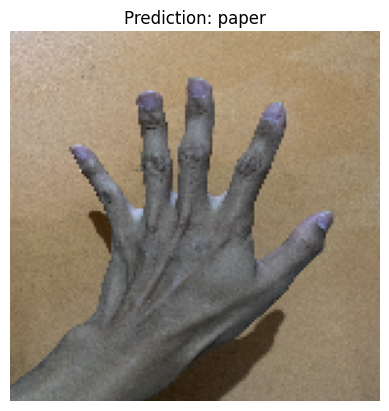

In [13]:
# Fungsi untuk memprediksi kelas gambar yang diunggah
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    prediction = model.predict(img_array)
    class_names = ['paper', 'rock', 'scissors']
    return class_names[np.argmax(prediction)], img

# Fungsi untuk mengunggah file dan memprediksi gambar yang diunggah pengguna
def upload_and_predict():
    uploaded = files.upload()
    for fn in uploaded.keys():
        print(f'User uploaded file "{fn}"')
        prediction, img = predict_image(fn)
        print(f"Prediction: {prediction}")

        # Tampilkan gambar yang diupload
        plt.imshow(img)
        plt.title(f"Prediction: {prediction}")
        plt.axis('off')
        plt.show()

# Memanggil fungsi untuk mengunggah dan memprediksi gambar
upload_and_predict()